In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as K
from tensorflow.keras.applications import ResNet50, VGG19, VGG16
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.utils import shuffle
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import StandardScaler
from sklearn.svm import OneClassSVM, SVC
from sklearn.decomposition import PCA
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN, SMOTETomek
import seaborn as sns


In [2]:
# Loading the data

X_labeled = np.load("Xtrain1.npy")
X_unlabeled = np.load("Xtrain1_extra.npy")
Y_train_labeled = np.load("Ytrain1.npy")
X_test = np.load("Xtest1.npy")

(2783, 2304)
(904, 2304)


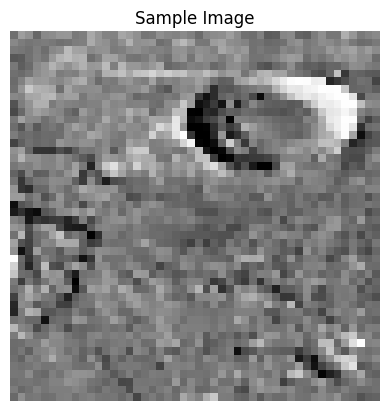

In [3]:
# Checking the shape of the data

print(X_labeled.shape)
print(X_unlabeled.shape)

# Normalization

X_labeled = X_labeled/255
X_unlabeled = X_unlabeled/255
X_test = X_test/255

# Turning the data into 2D

resized = np.resize(X_labeled[1], [48,48])
plt.imshow(resized, cmap='gray')
plt.title("Sample Image")
plt.axis('off')
plt.show()

In [ ]:
# Data Imbalance

crater_images = sum(Y_train_labeled)
no_crater_images = len(Y_train_labeled) - crater_images
ratio_no_crater_crater = no_crater_images/crater_images
print("Number of crater images: ", crater_images)
print("Number of no crater images: ", no_crater_images)
print("Ratio no crater/crater: ", ratio_no_crater_crater)

# Class Weights

class_weights_first = compute_class_weight(class_weight='balanced', classes=np.unique(Y_train_labeled), y=Y_train_labeled.flatten())
class_weight_dict_first = dict(enumerate(class_weights_first))
print("Class weights: ", class_weight_dict_first)

In [48]:
# Reshaping and Data Splitting

X_train_reshaped = X_labeled.reshape(len(X_labeled), 48, 48, 1)
X_unlabeled_train = X_unlabeled.reshape(len(X_unlabeled), 48, 48, 1)
X_test_reshaped = X_test.reshape(len(X_test), 48, 48, 1)

X_train, X_val, Y_train, Y_val = train_test_split(X_train_reshaped, Y_train_labeled, test_size=0.2, random_state=42)

Methods for Data Imbalance: Data Augmentation only on Minority Class

Data augmentation is a technique that can be used to improve the robustness and accuracy of a machine learning model by creating additional examples from the original dataset.

https://www.picsellia.com/post/improve-imbalanced-datasets-in-computer-vision


In [ ]:
# Finding the number of samples in each class

majority_indices = np.where(Y_train == 1)[0]
minority_indices = np.where(Y_train == 0)[0]

X_train_majority = X_train[majority_indices]
X_train_minority = X_train[minority_indices]

target_minority_samples = len(X_train_majority)
num_augmented_samples = target_minority_samples - len(X_train_minority)

datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

augmented_minority_images = []
for i in range(num_augmented_samples):
    img = X_train_minority[i % len(X_train_minority)].reshape((1, 48, 48, 1))
    augmented_img = next(datagen.flow(img, batch_size=1))[0]
    augmented_minority_images.append(augmented_img)

X_train_minority_balanced = np.concatenate([X_train_minority, np.array(augmented_minority_images)])
Y_train_minority_balanced = np.zeros(len(X_train_minority_balanced))

X_train_balanced_DA = np.concatenate([X_train_majority, X_train_minority_balanced])
Y_train_balanced_DA = np.concatenate([np.ones(len(X_train_majority)), Y_train_minority_balanced])

indices = np.arange(len(Y_train_balanced_DA))
np.random.shuffle(indices)
X_train_balanced_DA, Y_train_balanced_DA = X_train_balanced_DA[indices], Y_train_balanced_DA[indices]

print("Balanced training set shape:", X_train_balanced_DA.shape)
print("Balanced class distribution:", np.bincount(Y_train_balanced_DA.astype(int)))

Methods for Data Imbalance: Random Sampling

https://medium.com/@shubhamgupta.3101994/addressing-data-imbalance-in-image-classification-techniques-and-strategies-b922fb3c5124
https://machinelearningmastery.com/random-oversampling-and-undersampling-for-imbalanced-classification/

There are two main approaches to random resampling for imbalanced classification; they are oversampling and undersampling.

 - Random Oversampling: Randomly duplicate examples in the minority class.
 - Random Undersampling: Randomly delete examples in the majority class.

Random resampling provides a naive technique for rebalancing the class distribution for an imbalanced dataset.
Random oversampling duplicates examples from the minority class in the training dataset and can result in overfitting for some models.

Random undersampling deletes examples from the majority class and can result in losing information invaluable to a model.

Random Over Sampling (ROS)

In [ ]:
X_train_flattened = X_train_balanced_DA.reshape(len(X_train_balanced_DA), -1)
ros = RandomOverSampler(sampling_strategy='auto', random_state=42)
X_train_ROS, Y_train_ROS = ros.fit_resample(X_train_flattened, Y_train_balanced_DA)
X_train_ROS = X_train_ROS.reshape(-1, 48, 48, 1)
unique, counts = np.unique(Y_train_ROS, return_counts=True)
print("Balanced class distribution:", dict(zip(unique, counts)))

print(X_train_ROS.shape)
print(Y_train_ROS.shape)

Random Under Sampling (RUS)

In [ ]:
X_train_flattened = X_train.reshape(len(X_train), -1)

rus = RandomUnderSampler(sampling_strategy='auto', random_state=42)

X_train_RUS, Y_train_RUS = rus.fit_resample(X_train_flattened, Y_train)
X_train_RUS = X_train_RUS.reshape(-1, 48, 48, 1)

unique, counts = np.unique(Y_train_RUS, return_counts=True)

print("Balanced class distribution:", dict(zip(unique, counts)))

Combination of ROS and RUS

In [ ]:
X_train_flattened = X_train.reshape(len(X_train), -1)

ros = RandomOverSampler(sampling_strategy=0.95, random_state=42)

X_train_over, Y_train_over = ros.fit_resample(X_train_flattened, Y_train)

rus = RandomUnderSampler(sampling_strategy=1.0, random_state=42)

X_train_both, Y_train_both = rus.fit_resample(X_train_over, Y_train_over)

X_train_both = X_train_both.reshape(-1, 48, 48, 1)

unique, counts = np.unique(Y_train_over, return_counts=True)

print("Final balanced class distribution:", dict(zip(unique, counts)))

In [ ]:
# Build CNN model
def create_model():
    model = Sequential()

    # Convolutional Layer 1
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(48, 48, 1)))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Convolutional Layer 2
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Convolutional Layer 3
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Flattening
    model.add(Flatten())

    # Fully connected layer with dropout
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))

    # Output layer (binary classification)
    model.add(Dense(1, activation='sigmoid'))
    adam = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8) # NAO MEXE, NAO MUDA, NAO RESPIRA
    # Compile the model
    model.compile(optimizer= adam, loss='binary_crossentropy', metrics=['accuracy'])

    return model


model = create_model()
model.summary()

# Train the model
batch_size = 32
epochs = 100

early_stopping = EarlyStopping(
    monitor='val_loss',     # Metric to monitor
    patience=5, # Number of epochs to wait for improvement
    restore_best_weights=True  # Restore weights from the best epoch
)


# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(Y_train_both), y=Y_train_both)
class_weights_dict = dict(enumerate(class_weights))


history = model.fit(
    X_train_both, Y_train_both,
    validation_data=(X_val, Y_val),
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[early_stopping],
    class_weight=class_weights_dict
    )


# Evaluate the model
val_preds = model.predict(X_val)

val_preds = np.round(val_preds)
print(val_preds)

# Classification report
print(classification_report(Y_val, val_preds))

# F1 Score
f1 = f1_score(Y_val, val_preds, average = 'macro')
print("F1 Score: ", f1)

# Confusion Matrix
conf_matrix = confusion_matrix(Y_val, val_preds)
print("Confusion Matrix:\n", conf_matrix)

# Plotting training history
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()


Pre-Trained VGG19

In [ ]:
X_train_rgb = np.repeat(X_train_both, 3, axis=-1)  # Converts (48, 48, 1) to (48, 48, 3)
X_val_rgb = np.repeat(X_val, 3, axis=-1)

base_model = VGG19(weights='imagenet', include_top=False, input_shape=(48, 48, 3))

# Freeze the initial layers of VGG19 to retain pre-trained features
for layer in base_model.layers[:-8]:  # Adjust number of layers to unfreeze more, if necessary
    layer.trainable = False

# Add custom classification layers on top
x = base_model.output
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
x= Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)

# Define the model
model = Model(inputs=base_model.input, outputs=x)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    X_train_rgb, Y_train_both, 
    batch_size=32,
    validation_data=(X_val_rgb, Y_val),
    epochs=30,
    callbacks = [early_stopping]
)

val_preds = model.predict(X_val_rgb)
val_preds = np.round(val_preds)

# Classification report
print(classification_report(Y_val, val_preds))

# F1 Score
f1 = f1_score(Y_val, val_preds, average='macro')
print("F1 Score: ", f1)

# Confusion Matrix
conf_matrix = confusion_matrix(Y_val, val_preds)
print("Confusion Matrix:\n", conf_matrix)

# Plotting training history
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

Pre-trained VGG16

In [ ]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(48, 48, 3))

for layer in base_model.layers[:-8]:
    layer.trainable = False

x = base_model.output
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=x)
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(
    X_train_rgb, Y_train_both,
    batch_size=32, 
    validation_data=(X_val_rgb, Y_val),
    epochs=30,
    callbacks = [early_stopping]
)

val_preds = model.predict(X_val_rgb)
val_preds = np.round(val_preds)

# Classification report
print(classification_report(Y_val, val_preds))

# F1 Score
f1 = f1_score(Y_val, val_preds, average='macro')
print("F1 Score: ", f1)

# Confusion Matrix
conf_matrix = confusion_matrix(Y_val, val_preds)
print("Confusion Matrix:\n", conf_matrix)

# Plotting training history
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

Using the unlabeled data

In [ ]:
# Normalize the unlabeled data (values between 0 and 1)
X_unlabeled_norm = X_unlabeled
X_unlabeled_norm = X_unlabeled_norm.reshape(X_unlabeled_norm.shape[0], 48, 48, 1)

# Train the CNN model on labeled data first (the code you already have)

model = create_model()
model.summary()

batch_size = 32
epochs = 30

early_stopping = EarlyStopping(
    monitor='val_loss',     # Metric to monitor
    patience=5, # Number of epochs to wait for improvement
    restore_best_weights=True  # Restore weights from the best epoch
)

# Train the model on the labeled dataset
history = model.fit(
    X_train_both, Y_train_both,
    validation_data=(X_val, Y_val),
    epochs=epochs,
    callbacks = [early_stopping]
)

# Use the trained CNN model to generate pseudo-labels for the unlabeled data
# Get predictions for the unlabeled data
unlabeled_preds = model.predict(X_unlabeled_norm)
print(unlabeled_preds)

# Threshold to assign pseudo-labels based on prediction confidence
pseudo_labels = np.where(unlabeled_preds > 0.95, 1, np.where(unlabeled_preds < 0.05, 0, -1))

# Only keep confident predictions (those with pseudo-labels not equal to -1)
confident_indices = np.where(pseudo_labels != -1)[0]
X_confident = X_unlabeled_norm[confident_indices]
pseudo_labels_confident = pseudo_labels[confident_indices]

# Reshape pseudo_labels_confident if needed
pseudo_labels_confident = pseudo_labels_confident.ravel()

# Combine the original labeled data with the pseudo-labeled confident data
X_combined = np.concatenate((X_train, X_confident), axis=0)
y_combined = np.concatenate((Y_train, pseudo_labels_confident), axis=0)

print(X_combined.shape)

early_stopping = EarlyStopping(
    monitor='val_loss',     # Metric to monitor
    patience=5, # Number of epochs to wait for improvement
    restore_best_weights=True  # Restore weights from the best epoch
)


# Retrain the model using the combined labeled + pseudo-labeled data
model = create_model()  # Recreate the model to retrain
history_combined = model.fit(
    X_combined, y_combined,
    validation_data=(X_val, Y_val),
    epochs=epochs,
    callbacks = [early_stopping]
)

# Step 5: Evaluate the model
val_preds = model.predict(X_val)
val_preds = np.round(val_preds)
plt.hist(np.where((unlabeled_preds > 0.05) & (unlabeled_preds < 0.95)))
plt.show()

# Classification report
print(classification_report(Y_val, val_preds))

# F1 Score
f1 = f1_score(Y_val, val_preds, average='macro')
print("F1 Score after self-training: ", f1)

# Confusion Matrix
conf_matrix = confusion_matrix(Y_val, val_preds)
print("Confusion Matrix after self-training:\n", conf_matrix)

# Step 6: Plotting training history for combined data
plt.plot(history_combined.history['accuracy'], label='train accuracy')
plt.plot(history_combined.history['val_accuracy'], label='validation accuracy')
plt.title('Model Accuracy After Self-Training')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

plt.plot(history_combined.history['loss'], label='train loss')
plt.plot(history_combined.history['val_loss'], label='validation loss')
plt.title('Model Loss After Self-Training')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()


With CV

In [ ]:
# Define K-Fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)  # 5-fold cross-validation

# Initialize lists to store metrics
f1_scores = []
histories = []

# Perform K-Fold Cross-Validation
fold = 1
for train_index, val_index in kf.split(X_labeled):
    print(f"Training on Fold {fold}...")

    # Ensure indices are within bounds
    train_index = train_index[train_index < len(X_train_both)]
    val_index = val_index[val_index < len(X_train_both)]

    # Split the data into training and validation sets
    X_train, X_val = X_train_both[train_index], X_train_both[val_index]
    y_train, y_val = Y_train_both[train_index], Y_train_both[val_index]

    
    # Create a new CNN model for each fold
    model = create_model()
    
    early_stopping = EarlyStopping(
    monitor='val_loss',    
    patience=5, 
    restore_best_weights=True  
    )

    # Train the model with data augmentation
    history = model.fit(
        X_train, y_train, 
        batch_size=32, 
        validation_data=(X_val.reshape(X_val.shape[0], 48, 48, 1), y_val),  # Ensure X_val has shape (48, 48, 1)
        epochs=20,
        callbacks = [early_stopping]
    )
    
    # Append the training history for later analysis
    histories.append(history.history)
    
    # Evaluate the model
    val_preds = model.predict(X_val.reshape(X_val.shape[0], 48, 48, 1))
    val_preds = np.round(val_preds)  # Convert probabilities to binary 0 or 1

    # Calculate and store the F1 score
    f1 = f1_score(y_val, val_preds)
    f1_scores.append(f1)

    print(f"F1 Score for Fold {fold}: {f1}")

    # Confusion Matrix
    conf_matrix = confusion_matrix(y_val, val_preds)
    print(f"Confusion Matrix for Fold {fold}:\n", conf_matrix)

    # Increment fold number
    fold += 1

# Print average F1 score
print(f"\nAverage F1 Score: {np.mean(f1_scores)}")

# Plot accuracy and loss curves
for i, history in enumerate(histories):
    plt.plot(history['accuracy'], label=f'Fold {i+1} Train Accuracy')
    plt.plot(history['val_accuracy'], label=f'Fold {i+1} Validation Accuracy')
plt.title('Model Accuracy Across Folds')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

for i, history in enumerate(histories):
    plt.plot(history['loss'], label=f'Fold {i+1} Train Loss')
    plt.plot(history['val_loss'], label=f'Fold {i+1} Validation Loss')
plt.title('Model Loss Across Folds')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

Using a CNN for feature extraction and training the model with a DNN

In [ ]:
# Using reshaped training data (labeled)
x_label = X_train_both  # original labeled data (training set)
y_label = Y_train_both  # original labeled data (labels)

# Define K-Fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)  # 5-fold cross-validation

# Initialize lists to store metrics
f1_scores = []
histories = []

# Build the CNN feature extractor model
def create_cnn_feature_extractor():
    inputs = Input(shape=(48, 48, 1))
    
    # Convolutional Layer 1
    x = Conv2D(32, kernel_size=(3, 3), activation='relu')(inputs)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    # Convolutional Layer 2
    x = Conv2D(64, kernel_size=(3, 3), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    # Convolutional Layer 3
    x = Conv2D(128, kernel_size=(3, 3), activation='relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    # Flattening
    x = Flatten()(x)

    return Model(inputs, x)

# Build the DNN model
def create_dnn(input_shape):
    inputs = Input(shape=input_shape)
    x = Dense(128, activation='relu')(inputs)
    x = Dropout(0.5)(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(1, activation='sigmoid')(x)  # Binary classification
    
    return Model(inputs, outputs)

# Perform K-Fold Cross-Validation
fold = 1
for train_index, val_index in kf.split(x_label):
    print(f"Training on Fold {fold}...")
    
    # Split the data into training and validation sets
    X_train, X_val = x_label[train_index], x_label[val_index]
    y_train, y_val = y_label[train_index], y_label[val_index]  # Corrected

    # Convert labels to binary (0 or 1)
    y_train_binary = np.round(y_train).astype(int)  # Binary labels
    y_val_binary = np.round(y_val).astype(int)

    # Shuffle the resampled training data
    X_train, y_train_binary = shuffle(X_train, y_train_binary, random_state=42)
    
    # Reshape the validation data to match CNN input
    X_train = X_train.reshape((X_train.shape[0], 48, 48, 1))
    X_val = X_val.reshape((X_val.shape[0], 48, 48, 1))

    # Create CNN feature extractor
    cnn_feature_extractor = create_cnn_feature_extractor()
    cnn_features_train = cnn_feature_extractor.predict(X_train)
    cnn_features_val = cnn_feature_extractor.predict(X_val)
    
    # Flatten the CNN features
    cnn_features_train = cnn_features_train.reshape((cnn_features_train.shape[0], -1))  # Flatten the features
    cnn_features_val = cnn_features_val.reshape((cnn_features_val.shape[0], -1))  # Flatten the features
    
    # Create the DNN model
    dnn_model = create_dnn(cnn_features_train.shape[1:])
    
    # Compile the DNN model
    dnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Early stopping
    early_stopping = EarlyStopping(
        monitor='val_loss',     # Metric to monitor
        patience=5,             # Number of epochs to wait for improvement
        restore_best_weights=True  # Restore weights from the best epoch
    )

    # Ensure that y_train_binary and y_val_binary are reshaped to (batch_size, 1)
    y_train_binary = y_train_binary.reshape((-1, 1))
    y_val_binary = y_val_binary.reshape((-1, 1))

    print("Shape of y_train_binary after reshaping:", y_train_binary.shape)
    print("Shape of y_val_binary after reshaping:", y_val_binary.shape)

    # Train the DNN model
    history = dnn_model.fit(
        cnn_features_train, y_train_binary,
        validation_data=(cnn_features_val, y_val_binary),
        epochs=30,
        batch_size=32,
        callbacks=[early_stopping]
    )
    
    # Append the training history for later analysis
    histories.append(history.history)
    
    # Evaluate the DNN model
    val_preds = dnn_model.predict(cnn_features_val)
    val_preds = np.round(val_preds).astype(int)  # Convert probabilities to binary 0 or 1

    # Calculate and store the F1 score
    f1 = f1_score(y_val_binary, val_preds)
    f1_scores.append(f1)

    print(f"F1 Score for Fold {fold}: {f1}")

    # Confusion Matrix
    conf_matrix = confusion_matrix(y_val_binary, val_preds)
    print(f"Confusion Matrix for Fold {fold}:\n", conf_matrix)

    # Increment fold number
    fold += 1

# Print average F1 score
print(f"\nAverage F1 Score: {np.mean(f1_scores)}")

# Plot accuracy and loss curves
for i, history in enumerate(histories):
    plt.plot(history['accuracy'], label=f'Fold {i+1} Train Accuracy')
    plt.plot(history['val_accuracy'], label=f'Fold {i+1} Validation Accuracy')
plt.title('Model Accuracy Across Folds')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

for i, history in enumerate(histories):
    plt.plot(history['loss'], label=f'Fold {i+1} Train Loss')
    plt.plot(history['val_loss'], label=f'Fold {i+1} Validation Loss')
plt.title('Model Loss Across Folds')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()


CNN + DNN + Unlabeled data

In [ ]:
# Using reshaped training data (labeled)
x_label = X_combined  # original labeled data (training set)
y_label = y_combined  # original labeled data (labels)

# Define K-Fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)  # 5-fold cross-validation

# Initialize lists to store metrics
f1_scores = []
histories = []


# Perform K-Fold Cross-Validation
fold = 1
for train_index, val_index in kf.split(x_label):
    print(f"Training on Fold {fold}...")
    
    # Split the data into training and validation sets
    X_train, X_val = x_label[train_index], x_label[val_index]
    y_train, y_val = y_label[train_index], y_label[val_index]  # Corrected

    # Convert labels to binary (0 or 1)
    y_train_binary = np.round(y_train).astype(int)  # Binary labels
    y_val_binary = np.round(y_val).astype(int)

    # Shuffle the resampled training data
    X_train, y_train_binary = shuffle(X_train, y_train_binary, random_state=42)
    
    # Reshape the validation data to match CNN input
    X_train = X_train.reshape((X_train.shape[0], 48, 48, 1))
    X_val = X_val.reshape((X_val.shape[0], 48, 48, 1))

    # Create CNN feature extractor
    cnn_feature_extractor = create_cnn_feature_extractor()
    cnn_features_train = cnn_feature_extractor.predict(X_train)
    cnn_features_val = cnn_feature_extractor.predict(X_val)
    
    # Flatten the CNN features
    cnn_features_train = cnn_features_train.reshape((cnn_features_train.shape[0], -1))  # Flatten the features
    cnn_features_val = cnn_features_val.reshape((cnn_features_val.shape[0], -1))  # Flatten the features
    
    # Create the DNN model
    dnn_model = create_dnn(cnn_features_train.shape[1:])
    
    # Compile the DNN model
    dnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Early stopping
    early_stopping = EarlyStopping(
        monitor='val_loss',     # Metric to monitor
        patience=5,             # Number of epochs to wait for improvement
        restore_best_weights=True  # Restore weights from the best epoch
    )

    # Ensure that y_train_binary and y_val_binary are reshaped to (batch_size, 1)
    y_train_binary = y_train_binary.reshape((-1, 1))
    y_val_binary = y_val_binary.reshape((-1, 1))

    print("Shape of y_train_binary after reshaping:", y_train_binary.shape)
    print("Shape of y_val_binary after reshaping:", y_val_binary.shape)

    # Train the DNN model
    history = dnn_model.fit(
        cnn_features_train, y_train_binary,
        validation_data=(cnn_features_val, y_val_binary),
        epochs=30,
        batch_size=32,
        callbacks=[early_stopping]
    )
    
    # Append the training history for later analysis
    histories.append(history.history)
    
    # Evaluate the DNN model
    val_preds = dnn_model.predict(cnn_features_val)
    val_preds = np.round(val_preds).astype(int)  # Convert probabilities to binary 0 or 1

    # Calculate and store the F1 score
    f1 = f1_score(y_val_binary, val_preds)
    f1_scores.append(f1)

    print(f"F1 Score for Fold {fold}: {f1}")

    # Confusion Matrix
    conf_matrix = confusion_matrix(y_val_binary, val_preds)
    print(f"Confusion Matrix for Fold {fold}:\n", conf_matrix)

    # Increment fold number
    fold += 1

# Print average F1 score
print(f"\nAverage F1 Score: {np.mean(f1_scores)}")

# Plot accuracy and loss curves
for i, history in enumerate(histories):
    plt.plot(history['accuracy'], label=f'Fold {i+1} Train Accuracy')
    plt.plot(history['val_accuracy'], label=f'Fold {i+1} Validation Accuracy')
plt.title('Model Accuracy Across Folds')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

for i, history in enumerate(histories):
    plt.plot(history['loss'], label=f'Fold {i+1} Train Loss')
    plt.plot(history['val_loss'], label=f'Fold {i+1} Validation Loss')
plt.title('Model Loss Across Folds')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()
